In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict, Counter
import itertools
from pathlib import Path

import datasets
import duckdb
import lemminflect
import matplotlib.pyplot as plt
from matplotlib import transforms
import nltk
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import seaborn as sns
import torch
from tqdm.auto import tqdm

from src.analysis.state_space import StateSpaceAnalysisSpec, \
    prepare_state_trajectory, aggregate_state_trajectory, flatten_trajectory
from src.datasets.speech_equivalence import SpeechEquivalenceDataset

In [3]:
base_model = "w2v2_8"
model_class = "discrim-rnn_32-mAP1"
model_name = "word_broad_10frames_fixedlen25"
train_dataset = "librispeech-train-clean-100"
model_dir = f"outputs/models/{train_dataset}/{base_model}/{model_class}/{model_name}"
output_dir = f"."
dataset_path = f"outputs/preprocessed_data/{train_dataset}"
equivalence_path = f"outputs/equivalence_datasets/{train_dataset}/{base_model}/{model_name}/equivalence.pkl"
hidden_states_path = f"outputs/hidden_states/{train_dataset}/{base_model}/{train_dataset}.h5"
state_space_specs_path = f"outputs/state_space_specs/{train_dataset}/{base_model}/state_space_specs.h5"
embeddings_path = f"outputs/model_embeddings/{train_dataset}/{base_model}/{model_class}/{model_name}/{train_dataset}.npy"

seed = 1234

max_samples_per_word = 100

metric = "cosine"

agg_fns = [
    "mean",
]

In [4]:
with open(embeddings_path, "rb") as f:
    model_representations: np.ndarray = np.load(f)
state_space_spec = StateSpaceAnalysisSpec.from_hdf5(state_space_specs_path, "word")
assert state_space_spec.is_compatible_with(model_representations)

In [5]:
state_space_spec = state_space_spec.subsample_instances(max_samples_per_word)

In [6]:
trajectory = prepare_state_trajectory(model_representations, state_space_spec, pad=np.nan)

In [7]:
trajectory_aggs = {agg_fn: aggregate_state_trajectory(trajectory, state_space_spec, agg_fn, keepdims=True)
                   for agg_fn in tqdm(agg_fns)}

  0%|          | 0/1 [00:00<?, ?it/s]

Aggregating:   0%|          | 0/32046 [00:00<?, ?label/s]

In [8]:
trajectory_aggs_flat = {k: flatten_trajectory(v) for k, v in trajectory_aggs.items()}

In [9]:
cuts_df = state_space_spec.cuts.xs("phoneme", level="level").drop(columns=["onset_frame_idx", "offset_frame_idx"])
cuts_df["label_idx"] = cuts_df.index.get_level_values("label").map({l: i for i, l in enumerate(state_space_spec.labels)})
cuts_df["frame_idx"] = cuts_df.groupby(["label", "instance_idx"]).cumcount()
cuts_df = cuts_df.reset_index().set_index(["label", "instance_idx", "frame_idx"]).sort_index()
cuts_df

description  item_idx  label_idx
label   instance_idx frame_idx                                 
a       0            0                  AH       930         15
        1            0                  AH      9179         15
        2            0                  AH     16843         15
        3            0                  AH      3602         15
        4            0                  AH     22348         15
...                                    ...       ...        ...
zverkov 15           1                   V     15117      24522
                     2                  ER     15117      24522
                     3                   K     15117      24522
                     4                  AO     15117      24522
                     5                   V     15117      24522

[1778875 rows x 3 columns]

In [10]:
cut_phonemic_forms = cuts_df.groupby(["label", "instance_idx"]).description.agg(' '.join)
cut_phonemic_forms

label    instance_idx
a        0                          AH
         1                          AH
         2                          AH
         3                          AH
         4                          AH
                             ...      
zverkov  11              Z V ER K AO V
         12              Z V ER K AO V
         13              Z V ER K AO V
         14              Z V ER K AO V
         15              Z V ER K AO V
Name: description, Length: 334008, dtype: object

In [11]:
def estimate_analogy(triple, agg_method="mean", num_samples=50, k=20, verbose=False):
    """
    Returns:
    - result_df: a df describing the k nearest neighbors to the analogy vector in each sample
    - difference_vectors: the difference vectors used in the analogy for each sample
    - analogy_vectors: the analogy vectors for each sample
    """

    word_a, word_b, word_c, expected = triple
    assert word_a in state_space_spec.labels
    assert word_b in state_space_spec.labels
    assert word_c in state_space_spec.labels

    # if the expected word isn't in the vocabulary, this isn't really interpretable
    assert expected in state_space_spec.labels

    word_a_idx = state_space_spec.labels.index(word_a)
    word_b_idx = state_space_spec.labels.index(word_b)
    word_c_idx = state_space_spec.labels.index(word_c)

    # collect results of a - b
    difference_vectors = []
    # collect results of a - b + c
    analogy_vectors = []

    for _ in range(num_samples):
        word_a_instance = np.random.choice(min(max_samples_per_word, len(state_space_spec.target_frame_spans[word_a_idx])))
        word_b_instance = np.random.choice(min(max_samples_per_word, len(state_space_spec.target_frame_spans[word_b_idx])))
        word_c_instance = np.random.choice(min(max_samples_per_word, len(state_space_spec.target_frame_spans[word_c_idx])))

        word_a_traj = trajectory_aggs[agg_method][word_a_idx][word_a_instance].squeeze()
        word_b_traj = trajectory_aggs[agg_method][word_b_idx][word_b_instance].squeeze()
        word_c_traj = trajectory_aggs[agg_method][word_c_idx][word_c_instance].squeeze()

        difference_vector = word_a_traj - word_b_traj
        analogy_vector = difference_vector + word_c_traj

        difference_vectors.append(difference_vector)
        analogy_vectors.append(analogy_vector)

    difference_vectors = np.array(difference_vectors)
    analogy_vectors = np.array(analogy_vectors)

    references, references_src = trajectory_aggs_flat[agg_method]
    dists = cdist(analogy_vectors, references, metric=metric).mean(axis=0)
    ranks = dists.argsort()

    if verbose:
        for dist, (label_idx, instance_idx, _) in zip(dists[ranks[:k]], references_src[ranks[:k]]):
            print(dist, state_space_spec.labels[label_idx])

    ret = pd.DataFrame(references_src[ranks[:k]], columns=["label_idx", "instance_idx", "frame_idx"])
    ret["distance"] = dists[ranks[:k]]
    ret["label"] = [state_space_spec.labels[label_idx] for label_idx in ret["label_idx"]]
    return ret, difference_vectors, analogy_vectors

## Initial BATS study

In [13]:
# analogy_dataset = datasets.load_dataset("relbert/analogy_questions", "bats") \
#     ["test"].filter(lambda x: "morphology" in x["prefix"])

In [14]:
# difference_vectors = []
# prediction_results = []
# k = 20
# for item in tqdm(analogy_dataset):
#     b, a = item["stem"]
#     c, d = item["choice"][item["answer"]]
    
#     try:
#         ret, difference_vectors_i, _ = estimate_analogy((a, b, c, d), num_samples=100, k=k, verbose=False)
#     except AssertionError:
#         continue
    
#     nearest_neighbor = ret.iloc[0].label
#     prediction_results.append(
#         {"nearest_neighbor": nearest_neighbor,
#          "expected": d,
#          "correct": nearest_neighbor == d,
#          "correct_topk": d in ret.iloc[:k].label.tolist(),
#          "correct_position": ret[ret.label == d].index[0] if d in ret.label.values else None,
#          **item})
    
#     difference_vectors.append({"a": a, "b": b, "prefix": item["prefix"],
#                                "difference_vectors": difference_vectors_i})

In [15]:
# results_df = pd.DataFrame(prediction_results).drop(columns=["choice"])
# results_df.to_csv(Path(output_dir) / "analogy_results.csv", index=False)
# results_df

In [16]:
# summary_df = results_df.groupby("prefix").correct.agg(["count", "mean"]).sort_values("mean")
# summary_df.to_csv(Path(output_dir) / "analogy_summary.csv")
# summary_df

In [17]:
# torch.save(difference_vectors, Path(output_dir) / "analogy_difference_vectors.pt")

## Homegrown study

In [11]:
def get_inflection(word, all_labels, target) -> set[str]:
    if target in ("VBD", "VBZ", "VBG", "NNS"):
        inflections = set(lemminflect.getInflection(word, tag=target, inflect_oov=False))
        # don't include zero-derived form
        inflections -= {word}
    elif target == "NOT-latin":
        inflections = {"in" + word}
        if word[0] == "l":
            inflections |= {"il" + word}
        elif word[0] in ["p", "b", "m"]:
            inflections |= {"im" + word}
        elif word[0] == "r":
            inflections |= {"ir" + word}

        # catch exceptional cases -- these predicted forms are attested, but don't count
        # as a negative inflection. e.g. "come" -> "income"
        if word in ("come comes deed diana dies doors fancy form formation formed forming "
                    "habit jury justice k l laid land most n part parted port press pressed "
                    "prove proved pulse pulses side sight stead sure tend tended tending tent "
                    "to trusted vent ward"):
            inflections = set()
    else:
        raise ValueError(f"Unknown target: {target}")
    
    covered_inflections = inflections & all_labels
    return covered_inflections

In [12]:
inflection_targets = [
    ("VBD", "verb_inf - Ved"),
    ("VBZ", "verb_inf - 3pSg"),
    ("VBG", "verb_inf - Ving"),
    ("NNS", "noun - plural_reg"),
    ("NOT-latin", None),
]
labels = state_space_spec.label_counts
labels = set(labels[labels > 5].index)

inflection_results = {target: {} for target, _ in inflection_targets}
inflection_reverse = defaultdict(set)
for target, _ in tqdm(inflection_targets):
    for label in labels:
        label_inflections = get_inflection(label, labels, target)
        if label_inflections:
            inflection_results[target][label] = label_inflections

            for infl in label_inflections:
                inflection_reverse[infl].add((label, target))

from pprint import pprint
pprint({target: len(v) for target, v in inflection_results.items()})

ambiguous_inflected_forms = {k: v for k, v in inflection_reverse.items()
                             if len(v) > 1}
print(f"Ambiguous inflected forms ({len(ambiguous_inflected_forms)} total):")
print(" ".join(ambiguous_inflected_forms.keys()))

  0%|          | 0/5 [00:00<?, ?it/s]

{'NNS': 1175, 'NOT-latin': 38, 'VBD': 941, 'VBG': 574, 'VBZ': 721}
Ambiguous inflected forms (633 total):
bathed elbows volumes clocks bells seconds subjects mothers calls controls barrels honors paces merits hints takes gifts stands machines veils stations brooks paws glances guards kisses trials bundles ropes remedies comments states plates knees matters rules scales vines tasks cries spirits steps balls influences lines advantages journeys fishes gains boards flags faults needs rises champions lives shades fruits toes forms lips promises designs rivals holes carts resources nests boots bonds ears tanks furs ghosts profits clerks rooms fingers seeds numbers prints orders causes skins pipes brains roofs mills objects bulls rights knights tears marks trips sights forces meters signs visions chains kings keys views records supplies captains instances waters partners towers snakes lies scraps stones copies sizes plans tracks foxes robes provisions recesses tones matches stores bottoms pl

In [20]:
total_num_pairs = 400
k = 5
all_prediction_results = {}
all_difference_vectors = {}
for study_inflection, study_inflection_prefix in tqdm(inflection_targets):
    # generate random pairs for analogies
    candidate_bases = list(inflection_results[study_inflection].keys())
    candidate_pairs = list(itertools.combinations(candidate_bases, 2))
    np.random.seed(seed)
    np.random.shuffle(candidate_pairs)
    candidate_pairs = candidate_pairs[:total_num_pairs]

    difference_vectors = []
    prediction_results = []
    for (word1, word2) in tqdm(candidate_pairs, leave=False):
        a = next(iter(inflection_results[study_inflection][word1]))
        b = word1
        c = word2
        d = next(iter(inflection_results[study_inflection][word2]))
        print(a, b, c, d)
        
        try:
            ret, difference_vectors_i, _ = estimate_analogy((a, b, c, d), num_samples=100, k=k, verbose=False)
        except AssertionError:
            continue
        
        nearest_neighbor = ret.iloc[0].label
        prediction_results.append(
            {"a": a, "b": b, "c": c, "d": d,
            "d_pred": nearest_neighbor,
            "correct": nearest_neighbor == d,
            "correct_topk": d in ret.iloc[:k].label.tolist(),
            "correct_position": ret[ret.label == d].index[0] if d in ret.label.values else None})
        
        difference_vectors.append({"a": a, "b": b, "c": c, "prefix": study_inflection_prefix,
                                   "difference_vectors": difference_vectors_i})

    all_prediction_results[study_inflection] = pd.DataFrame(prediction_results)
    all_difference_vectors[study_inflection] = difference_vectors

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

marked mark go went
thought think finish finished
blocked block impose imposed
recovered recover fulfill fulfilled
smoothed smooth regain regained
tired tire experience experienced
married marry advise advised
recognized recognize ride rode
betrayed betray owe owed
bore bear dispute disputed
strolled stroll sweep swept
raised raise venture ventured
copied copy check checked
smoothed smooth try tried
aided aid hint hinted
informed inform hop hopped
chose choose recover recovered
resigned resign weigh weighed
fared fare heap heaped
favored favor peep peeped
hanged hang await awaited
whipped whip break broke
demanded demand greet greeted
judged judge dispatch dispatched
heard hear pack packed
gasped gasp expect expected
winged wing tear tore
occurred occur confide confided
acknowledged acknowledge associate associated
perceived perceive print printed
fell fall count counted
liked like labor labored
crooked crook inhabit inhabited
trusted trust shape shaped
encountered encounter draw drew


  0%|          | 0/400 [00:00<?, ?it/s]

witnesses witness link links
gardens garden mother mothers
resources resource allow allows
blankets blanket back backs
factors factor track tracks
summons summon meet meets
pictures picture bow bows
honors honor castle castles
doctors doctor present presents
murmurs murmur ball balls
baths bath play plays
sights sight string strings
shows show blanket blankets
writes write rope ropes
forces force learn learns
sentences sentence ornament ornaments
planks plank letter letters
shields shield limit limits
controls control regret regrets
regrets regret curtain curtains
pillars pillar gate gates
planks plank answer answers
goes go mine mines
pillars pillar tongue tongues
strokes stroke shape shapes
makes make have has
blocks block pit pits
burdens burden stop stops
rests rest course courses
cheers cheer link links
mothers mother occur occurs
ruins ruin heap heaps
becomes become circle circles
makes make blanket blankets
traces trace attack attacks
positions position curtain curtains
lights l

  0%|          | 0/400 [00:00<?, ?it/s]

awaiting await trust trusting
issuing issue cool cooling
regarding regard start starting
fighting fight betray betraying
reasoning reason pour pouring
encouraging encourage find finding
hiding hide interest interesting
communicating communicate destroy destroying
landing land happen happening
becoming become discover discovering
affecting affect frown frowning
leaning lean believe believing
thanking thank offer offering
amusing amuse lodge lodging
sewing sew decay decaying
obliging oblige satisfy satisfying
talking talk swell swelling
breathing breathe wish wishing
whirling whirl insult insulting
guessing guess grow growing
thrusting thrust start starting
joining join deliver delivering
seeing see bath bathing
surveying survey ring ringing
securing secure lack lacking
staying stay feed feeding
creating create feed feeding
glancing glance direct directing
rattling rattle flame flaming
spending spend dine dining
clinging cling belong belonging
bathing bathe save saving
visiting visit spe

  0%|          | 0/400 [00:00<?, ?it/s]

treasures treasure newspaper newspapers
attitudes attitude motion motions
towns town train trains
exertions exertion tongue tongues
valleys valley chain chains
sciences science fruit fruits
forwards forward holiday holidays
sums sum ghost ghosts
intentions intention impulse impulses
men man grave graves
ships ship dress dresses
delights delight taste tastes
sleeves sleeve play plays
questions question regiment regiments
gods god hunter hunters
rulers ruler liberty liberties
profits profit daughter daughters
indications indication beginning beginnings
wits wit obstacle obstacles
goods good ideal ideals
losses loss show shows
inquiries inquiry partner partners
truths truth folk folks
forts fort sailor sailors
associations association mill mills
angles angle pipe pipes
gestures gesture champion champions
animals animal sledge sledges
tanks tank proportion proportions
convicts convict smile smiles
scenes scene seal seals
huts hut wave waves
coins coin boundary boundaries
rags rag contribut

  0%|          | 0/400 [00:00<?, ?it/s]

independent dependent distinct indistinct
indirectly directly voluntary involuntary
immortal mortal perfect imperfect
inability ability perfectly imperfectly
inconvenience convenience tolerable intolerable
imperfectly perfectly disposed indisposed
inconvenience convenience significant insignificant
involuntarily voluntarily perfect imperfect
independent dependent convenience inconvenience
indisposed disposed differently indifferently
incapable capable human inhuman
illegal legal patiently impatiently
inhuman human distinct indistinct
insane sane perfectly imperfectly
impossible possible dependent independent
inconsistent consistent regular irregular
improper proper definite indefinite
impossible possible legal illegal
inconsistent consistent differently indifferently
imprudent prudent mortality immortality
impatient patient consistent inconsistent
imprudent prudent mortal immortal
insensible sensible possibility impossibility
insufficient sufficient different indifferent
impossible pos

In [21]:
broad_inflection_results = pd.concat(all_prediction_results, names=["inflection"])
broad_inflection_results.to_csv(f"{output_dir}/broad_inflection_results.csv")

In [ ]:
torch.save(all_difference_vectors, Path(output_dir) / "broad_inflection_difference_vectors.pt")

### Analysis

In [13]:
broad_inflection_results = pd.read_csv(f"{output_dir}/broad_inflection_results.csv", index_col=[0, 1])
broad_inflection_results

a            b            c              d  \
inflection                                                               
VBD        0           marked         mark           go           went   
           1          thought        think       finish       finished   
           2          blocked        block       impose        imposed   
           3        recovered      recover      fulfill      fulfilled   
           4         smoothed       smooth       regain       regained   
...                       ...          ...          ...            ...   
NOT-latin  395      inability      ability        human        inhuman   
           396      inaudible      audible  significant  insignificant   
           397     insensible     sensible  voluntarily  involuntarily   
           398  indifferently  differently   difference   indifference   
           399     indisposed     disposed    mortality    immortality   

                       d_pred  correct  correct_topk  correct_position  
inflection                                                              
VBD        0               go    False         False               NaN  
           1       defrauding    False         False               NaN  
           2          imposed     True          True               0.0  
           3        fulfilled     True          True               0.0  
           4         regained     True          True               0.0  
...                       ...      ...           ...               ...  
NOT-latin  395        inhuman     True          True               0.0  
           396    significant    False         False               NaN  
           397  involuntarily     True          True               0.0  
           398   indifference     True          True               0.0  
           399    immortality     True          True               0.0  

[2000 rows x 8 columns]

In [14]:
all_difference_vectors = torch.load(Path(output_dir) / "broad_inflection_difference_vectors.pt")

In [39]:
broad_inflection_results.groupby("inflection").correct.mean().to_frame()

,correct
inflection,
NNS,0.6750
NOT-latin,0.5725
VBD,0.4475
VBG,0.6175
VBZ,0.6725


In [16]:
broad_inflection_results.groupby("inflection").correct_topk.mean().rename("correct").to_frame()

,correct
inflection,
NNS,0.8375
NOT-latin,0.7725
VBD,0.6225
VBG,0.7950
VBZ,0.8825


In [17]:
not_study = broad_inflection_results.loc["NOT-latin"]
not_study["map"] = not_study.a.str[:2] + "->" + not_study.d.str[:2]
not_study.groupby("map").correct_topk.agg(["count", "mean"])

/tmp/ipykernel_998407/2910239743.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_study["map"] = not_study.a.str[:2] + "->" + not_study.d.str[:2]


,count,mean
map,,
il->im,3,0.000000
il->in,7,0.714286
im->il,3,1.000000
im->im,30,0.966667
im->in,76,0.947368
im->ir,3,0.666667
in->il,8,0.750000
in->im,82,0.560976
in->in,172,0.802326


In [18]:
difference_vectors_flat = defaultdict(list)
for inflection, difference_vectors in all_difference_vectors.items():
    for dv in difference_vectors:
        difference_vectors_flat[inflection].append(dv["difference_vectors"].mean(0))
difference_vectors_flat = {k: np.array(v) for k, v in difference_vectors_flat.items()}

In [19]:
difference_difference_mat = np.zeros((len(inflection_targets), len(inflection_targets)))
for i, (inflection1, _) in enumerate(inflection_targets):
    for j, (inflection2, _) in enumerate(inflection_targets):
        difference_difference_mat[i, j] = cdist(difference_vectors_flat[inflection1],
                                                difference_vectors_flat[inflection2],
                                                metric=metric).mean()

<Axes: >

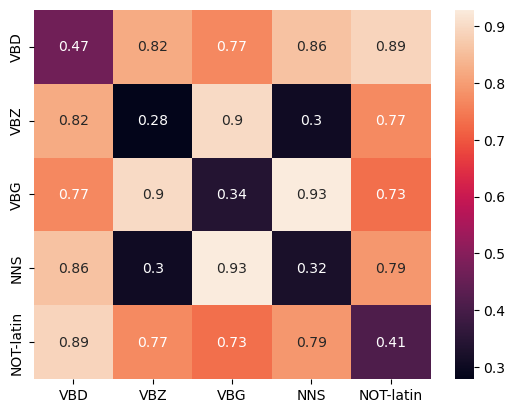

In [20]:
sns.heatmap(difference_difference_mat, annot=True, xticklabels=[t for t, _ in inflection_targets],
            yticklabels=[t for t, _ in inflection_targets])

In [47]:
glob = []
def run_counterfactual_study(study_inflection, num_divergence_contents=5,
                             num_word_samples=100,
                             num_instance_samples=50,
                             ignore_tags=("VBD", "VBN",),
                             agg_method="mean"):
    infl_results = broad_inflection_results.loc[study_inflection]
    infl_results = infl_results[["a", "b"]]
    post_divergence_contents = Counter()
    post_divergence_map = {}
    for _, (inflected_form, base_form) in infl_results.iterrows():
        base_cuts = cuts_df.loc[base_form]
        inflected_cuts = cuts_df.loc[inflected_form]

        # all attested phonological forms of base
        base_phono_forms = set(base_cuts.groupby("instance_idx").apply(
            lambda xs: tuple(xs.description)))

        post_divergence_i = Counter()
        for _, inflected_instance in inflected_cuts.groupby("instance_idx"):
            # phonological divergence point: latest point at which the inflected form overlaps with
            # any pronunciation of the base form
            inflected_phones = tuple(inflected_instance.description)
            phono_divergence_points = []
            for base_phones in base_phono_forms:
                for idx in range(len(inflected_phones) + 1):
                    if inflected_phones[:idx] != base_phones[:idx]:
                        break
                phono_divergence_points.append(idx - 1)
            phono_divergence_point = max(phono_divergence_points)

            if phono_divergence_point == 0:
                continue
            post_divergence_i[inflected_phones[phono_divergence_point:]] += 1

        if len(post_divergence_i) == 0:
            continue
        post_divergence_map[base_form] = post_divergence_i
        post_divergence_contents[post_divergence_i.most_common()[0][0]] += 1

    print(f"Post-divergence contents for {study_inflection}:")
    pprint(post_divergence_contents.most_common(10))

    # collect vectors by divergence content
    study_vectors = all_difference_vectors[study_inflection]
    study_vectors_flat = defaultdict(list)
    for dv in study_vectors:
        try:
            divergence, _ = post_divergence_map[dv["b"]].most_common()[0]
        except KeyError:
            # no divergence data was stored
            continue
        study_vectors_flat[divergence].extend(dv["difference_vectors"])

    study_vectors_flat = {k: np.array(v) for k, v in study_vectors_flat.items()}

    #### counterfactual study

    start_labels = state_space_spec.label_counts[state_space_spec.label_counts > 10].index

    exclude_base_forms = "a b bo co de d eh ha la ni r re pa y ye".split()
    start_labels = start_labels[~start_labels.isin(exclude_base_forms)]

    # prepare to look up attested phonemic forms with minimum frequency
    filtered_phonemic_forms = set(cut_phonemic_forms.loc[start_labels])
    instances_by_phonemic_form = cut_phonemic_forms.reset_index().set_index("description")
    instances_by_phonemic_form["label_idx"] = instances_by_phonemic_form.label.map({l: i for i, l in enumerate(state_space_spec.labels)})

    # prepare counterfactual vectors for each divergence content
    counterfactual_divergence_vectors = defaultdict(list)
    for post_divergence, _ in tqdm(post_divergence_contents.most_common(num_divergence_contents)):
        post_divergence_str = " ".join(post_divergence)

        # some good number of examples
        step0 = cut_phonemic_forms.loc[start_labels]
        # whole form has the same as the post-divergence content
        step1 = step0.loc[(step0.str[-len(post_divergence_str):] == post_divergence_str).groupby("label").transform("any")]
        # remove real inflection bases
        step2 = step1.loc[~step1.index.get_level_values("label").isin(inflection_results[study_inflection].keys())]
        # remove real inflections
        step3 = step2.loc[~step2.index.get_level_values("label").isin(list(itertools.chain.from_iterable(inflection_results[study_inflection].values())))]
        # and if you strip off the post-divergence content, it's still attested
        step4 = step3.loc[step3.str[:-len(post_divergence_str)].str.strip().isin(filtered_phonemic_forms)]
        # these shouldn't be attested within the same orthographic form
        # e.g. "second" has pronunciations as both "S EH K AH N D" and "S EH K AH N",
        # this shouldn't count
        step5 = step4.loc[step4.groupby("label").transform(
            lambda xs: len(np.intersect1d(xs.str[:-len(post_divergence_str)].str.strip(),
                                        cut_phonemic_forms.loc[xs.name])) == 0)]
        # exclude anything whose dominant POS is in the exclude list
        step5_labels = step5.index.get_level_values("label").unique()
        step5_exclude = {label: nltk.pos_tag(label.split())[0][1] in ignore_tags for label in step5_labels}
        step5_exclude = pd.Series(step5_exclude)

        # TODO exclude base--inflected counterfactual relations which are homophonic with
        # a real inflection

        # manual fixes
        if study_inflection == "NNS":
            ok_forms, bad_forms = [], []
            if post_divergence == ("Z",):
                # these forms are fine; they don't have the plural relationship with their base
                ok_forms = ("knows wise choose depends yours regards belongs gaze towards "
                            "seize theirs raise hers grows afterwards ease enters happens "
                            "begins contains sees surroundings feels opens becomes "
                            "backwards ours upwards hangs williams praise deserves "
                            "summons myles adams delawares").split()
                
                step5_exclude[step5_exclude.index.str.endswith("'s")] = False
                bad_forms = ("follows").split()
            elif post_divergence == ("S",):
                print("TODO")
            elif post_divergence == ("IH", "Z"):
                ok_forms = ["missus", "produces", "riches"]
            elif post_divergence == ("AH", "Z"):
                ok_forms = ["produces", "riches"]

            step5_exclude.loc[ok_forms] = False
            step5_exclude.loc[bad_forms] = True
        elif study_inflection == "VBD":
            ok_forms, bad_forms = [], []
            if post_divergence == ("D",):
                # bad_forms = ("tied").split()
                pass
            elif post_divergence == ("T",):
                bad_forms = ("missed passed massed guessed").split()

            try:
                step5_exclude.loc[ok_forms] = False
            except KeyError: pass

            try:
                step5_exclude.loc[bad_forms] = True
            except KeyError: pass

        step6 = step5.loc[~step5.index.get_level_values("label").isin(step5_exclude[step5_exclude].index)]
        print(post_divergence, len(step1), len(step2), len(step3), len(step4), len(step5), len(step6))
        glob.append((study_inflection, post_divergence_str, step5, step5_exclude))

        # Sample inflected forms
        sampled_inflected_forms: pd.Series[str] = pd.Series(step6.unique())  # type: ignore
        sampled_inflected_forms = sampled_inflected_forms.sample(min(num_word_samples, len(sampled_inflected_forms)))

        for form in sampled_inflected_forms:
            form_instances = step6[step6 == form].reset_index()
            form_instances["label_idx"] = form_instances.label.map({l: i for i, l in enumerate(state_space_spec.labels)})
            
            # Draw base forms
            base_form = form[:-len(post_divergence_str)].strip()
            base_instances = instances_by_phonemic_form.loc[[base_form]]

            # Sample instances
            num_instances = min(num_instance_samples, len(base_instances), len(form_instances))
            base_instances = base_instances.sample(num_instances)
            form_instances = form_instances.sample(num_instances)

            all_samples = []
            for (_, (base_row)), (_, (form_row)) in zip(base_instances.iterrows(), form_instances.iterrows()):
                base_sample = trajectory_aggs[agg_method][base_row.label_idx][base_row.instance_idx].squeeze()
                form_sample = trajectory_aggs[agg_method][form_row.label_idx][form_row.instance_idx].squeeze()

                print(base_row.label, base_form, "--", form_row.label, form)
                
                # take difference matching earlier evaluation
                all_samples.append(form_sample - base_sample)

            counterfactual_divergence_vectors[post_divergence].append(np.mean(all_samples, axis=0))

    counterfactual_divergence_vectors = {k: np.array(v) for k, v in counterfactual_divergence_vectors.items()}

    study_divergence_contents = [k for k, _ in post_divergence_contents.most_common(num_divergence_contents)]
    study_difference_difference_mat = np.zeros((len(study_divergence_contents), len(study_divergence_contents)))
    for i, div1 in enumerate(study_divergence_contents):
        for j, div2 in enumerate(study_divergence_contents):
            study_difference_difference_mat[i, j] = cdist(study_vectors_flat[div1],
                                                        study_vectors_flat[div2],
                                                        metric=metric).mean()
            
    sns.heatmap(study_difference_difference_mat, annot=True,
                xticklabels=study_divergence_contents, yticklabels=study_divergence_contents)
    
    control_study_results = []
    for div in study_divergence_contents:
        if div not in counterfactual_divergence_vectors:
            # no counterfactual examples
            continue
        within_div = cdist(study_vectors_flat[div], study_vectors_flat[div], metric=metric).mean()
        counterfactual_vectors = counterfactual_divergence_vectors[div]
        between_div = cdist(study_vectors_flat[div], counterfactual_vectors, metric=metric).mean()

        control_study_results.append({"divergence": " ".join(div), "within_div": within_div, "between_div": between_div})

    control_study_results_df = pd.DataFrame(control_study_results)
    return control_study_results_df

Post-divergence contents for VBD:
[(('D',), 193),
 (('T',), 73),
 (('IH', 'D'), 61),
 (('AH', 'D'), 12),
 (('OW', 'Z'), 5),
 (('UW',), 5),
 (('OW', 'K'), 4),
 (('AO', 'T'), 3),
 (('AO', 'S', 'T'), 3),
 (('UH', 'D'), 3)]


  0%|          | 0/5 [00:00<?, ?it/s]

('D',) 36507 32800 11727 2193 2022 1920
her HH ER -- herd HH ER D
her HH ER -- herd HH ER D
her HH ER -- herd HH ER D
her HH ER -- herd HH ER D
her HH ER -- herd HH ER D
her HH ER -- herd HH ER D
her HH ER -- herd HH ER D
her HH ER -- herd HH ER D
her HH ER -- herd HH ER D
her HH ER -- herd HH ER D
her HH ER -- herd HH ER D
her HH ER -- herd HH ER D
her HH ER -- herd HH ER D
her HH ER -- herd HH ER D
her HH ER -- herd HH ER D
her HH ER -- herd HH ER D
her HH ER -- herd HH ER D
her HH ER -- herd HH ER D
her HH ER -- herd HH ER D
her HH ER -- herd HH ER D
her HH ER -- herd HH ER D
bowl B OW L -- bold B OW L D
bowl B OW L -- bold B OW L D
bowl B OW L -- bold B OW L D
bowl B OW L -- bold B OW L D
bowl B OW L -- bold B OW L D
bowl B OW L -- bold B OW L D
bowl B OW L -- bold B OW L D
bowl B OW L -- bold B OW L D
bowl B OW L -- bold B OW L D
bowl B OW L -- bold B OW L D
bowl B OW L -- bold B OW L D
bowl B OW L -- bold B OW L D
bole B OW L -- bold B OW L D
bowl B OW L -- bold B OW L D
allow AH

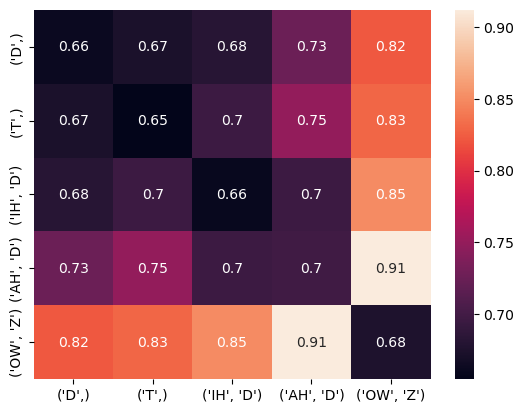

In [48]:
vbd_control_df = run_counterfactual_study("VBD", num_divergence_contents=5, ignore_tags=("VBD", "VBN"),
                         # DEV
                         # num_word_samples=2, num_instance_samples=2
                         num_word_samples=100, num_instance_samples=50)

Text(0, 0.5, 'Cosine distance')

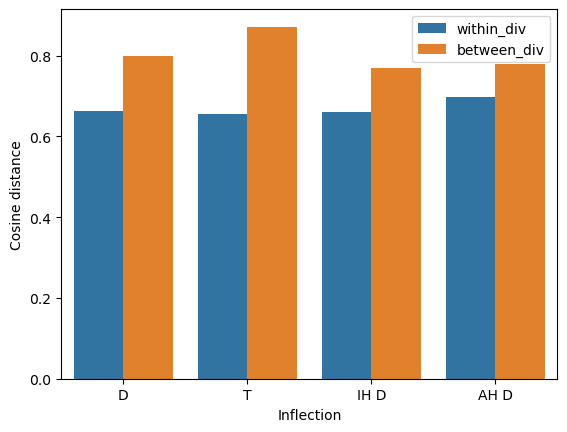

In [56]:
ax = sns.barplot(data=vbd_control_df.melt(id_vars=["divergence"]).query("divergence != 'OW Z'"), x="divergence", hue="variable", y="value")
ax.legend(loc="upper right")
ax.set_xlabel("Inflection")
ax.set_ylabel("Cosine distance")

In [26]:
sorted(vstep5.index.get_level_values("label").unique())

['ardent',
 'art',
 'aunt',
 'beat',
 'belt',
 'boat',
 "can't",
 'cart',
 'complaint',
 'court',
 'date',
 'drouet',
 'eight',
 'fault',
 'fleet',
 'flight',
 'fort',
 'gate',
 'gaunt',
 'great',
 'guest',
 'height',
 'hurt',
 'joint',
 'knight',
 'late',
 'leaped',
 'lest',
 'lot',
 'mast',
 'mate',
 'meat',
 'midst',
 'mist',
 'neat',
 'night',
 'ought',
 'past',
 'plate',
 'port',
 'pursuit',
 'rate',
 'rent',
 'root',
 'route',
 'shalt',
 'sheet',
 'short',
 'site',
 'sort',
 'spite',
 'tent',
 'that',
 'throat',
 'tight',
 'tut',
 'weight',
 'wheat',
 'white',
 'wilt',
 'worst',
 "wouldn't"]

In [27]:
vstep5_exclude

great     False
that      False
port      False
eight     False
midst     False
          ...  
neat      False
belt      False
wilt      False
gaunt     False
drouet    False
Length: 62, dtype: bool

In [28]:
vstep5_exclude[vstep5_exclude].index.tolist()

['leaped']

Post-divergence contents for NNS:
[(('Z',), 239),
 (('S',), 106),
 (('IH', 'Z'), 36),
 (('AH', 'Z'), 6),
 (('V', 'Z'), 3),
 (('IY', 'TH'), 2),
 (('AH',), 2),
 (('EH', 'N'), 1),
 (('IY', 'Z'), 1),
 (('AO', 'R', 'Z'), 1)]


  0%|          | 0/4 [00:00<?, ?it/s]

('Z',) 26080 25301 7991 4028 4028 3444
toby T OW B IY -- toby's T OW B IY Z
toby T OW B IY -- toby's T OW B IY Z
toby T OW B IY -- toby's T OW B IY Z
toby T OW B IY -- toby's T OW B IY Z
toby T OW B IY -- toby's T OW B IY Z
toby T OW B IY -- toby's T OW B IY Z
toby T OW B IY -- toby's T OW B IY Z
toby T OW B IY -- toby's T OW B IY Z
toby T OW B IY -- toby's T OW B IY Z
toby T OW B IY -- toby's T OW B IY Z
toby T OW B IY -- toby's T OW B IY Z
toby T OW B IY -- toby's T OW B IY Z
toby T OW B IY -- toby's T OW B IY Z
toby T OW B IY -- toby's T OW B IY Z
toby T OW B IY -- toby's T OW B IY Z
toby T OW B IY -- toby's T OW B IY Z
john JH AA N -- john's JH AA N Z
john JH AA N -- john's JH AA N Z
john JH AA N -- john's JH AA N Z
john JH AA N -- john's JH AA N Z
john JH AA N -- john's JH AA N Z
john JH AA N -- john's JH AA N Z
john JH AA N -- john's JH AA N Z
john JH AA N -- john's JH AA N Z
john JH AA N -- john's JH AA N Z
john JH AA N -- john's JH AA N Z
john JH AA N -- john's JH AA N Z
john J

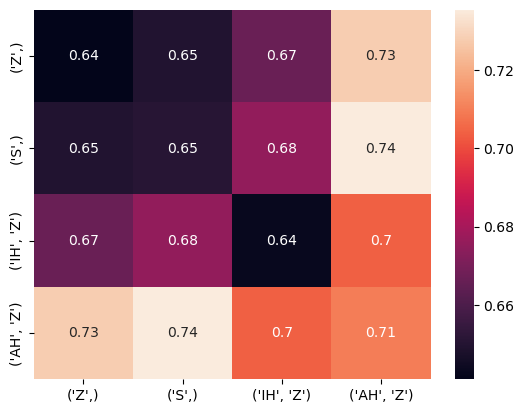

In [57]:
nns_control_df = run_counterfactual_study("NNS", num_divergence_contents=4, ignore_tags=("NN", "NNS"))

Text(0, 0.5, 'Cosine distance')

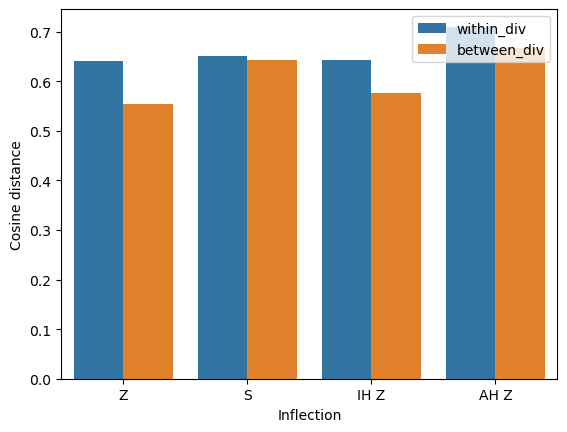

In [58]:
ax = sns.barplot(data=nns_control_df.melt(id_vars=["divergence"]).query("divergence != 'OW Z'"), x="divergence", hue="variable", y="value")
ax.legend(loc="upper right")
ax.set_xlabel("Inflection")
ax.set_ylabel("Cosine distance")

In [30]:
study_inflection = "VBD"
infl_results = broad_inflection_results.loc[study_inflection]
infl_results = infl_results[["a", "b"]]
# infl_results = pd.concat([infl_results[["a", "b"]],
#                           infl_results[["c", "d"]].rename(columns={"c": "b", "d": "a"})], axis=0)
post_divergence_contents = Counter()
post_divergence_map = {}
for _, (inflected_form, base_form) in infl_results.iterrows():
    base_cuts = cuts_df.loc[base_form]
    inflected_cuts = cuts_df.loc[inflected_form]

    # all attested phonological forms of base
    base_phono_forms = set(base_cuts.groupby("instance_idx").apply(
        lambda xs: tuple(xs.description)))

    post_divergence_i = Counter()
    for _, inflected_instance in inflected_cuts.groupby("instance_idx"):
        # phonological divergence point: latest point at which the inflected form overlaps with
        # any pronunciation of the base form
        inflected_phones = tuple(inflected_instance.description)
        phono_divergence_points = []
        for base_phones in base_phono_forms:
            for idx in range(len(inflected_phones) + 1):
                if inflected_phones[:idx] != base_phones[:idx]:
                    break
            phono_divergence_points.append(idx - 1)
        phono_divergence_point = max(phono_divergence_points)

        if phono_divergence_point == 0:
            continue
        post_divergence_i[inflected_phones[phono_divergence_point:]] += 1

    if len(post_divergence_i) == 0:
        continue
    post_divergence_map[base_form] = post_divergence_i
    post_divergence_contents[post_divergence_i.most_common()[0][0]] += 1

In [31]:
study_vectors = all_difference_vectors[study_inflection]
study_vectors_flat = defaultdict(list)
for dv in study_vectors:
    try:
        divergence, _ = post_divergence_map[dv["b"]].most_common()[0]
    except KeyError:
        # no divergence data was stored
        continue
    study_vectors_flat[divergence].extend(dv["difference_vectors"])

study_vectors_flat = {k: np.array(v) for k, v in study_vectors_flat.items()}

In [32]:
post_divergence_contents.most_common(10)

[(('D',), 193),
 (('T',), 73),
 (('IH', 'D'), 61),
 (('AH', 'D'), 12),
 (('OW', 'Z'), 5),
 (('UW',), 5),
 (('OW', 'K'), 4),
 (('AO', 'T'), 3),
 (('AO', 'S', 'T'), 3),
 (('UH', 'D'), 3)]

In [33]:
all_phonemic_forms = set(cut_phonemic_forms)

In [34]:
import nltk

In [35]:
num_divergence_contents = 5
num_word_samples = 50
num_instance_samples = 3
agg_method = "mean"

counterfactual_divergence_vectors = defaultdict(list)
for post_divergence, _ in tqdm(post_divergence_contents.most_common(num_divergence_contents)):
    post_divergence_str = " ".join(post_divergence)
    # Find items which exist with the same relationship -D and +D
    matching_ending = (cut_phonemic_forms.str[-len(post_divergence_str):] == post_divergence_str).groupby("label").any()

    # some good number of examples
    start_labels = state_space_spec.label_counts[state_space_spec.label_counts > 10].index
    step0 = cut_phonemic_forms.loc[start_labels]
    # whole form has the same as the post-divergence content
    step1 = step0.loc[(step0.str[-len(post_divergence_str):] == post_divergence_str).groupby("label").transform("any")]
    # remove real VBD bases
    step2 = step1.loc[~step1.index.get_level_values("label").isin(inflection_results["VBD"].keys())]
    # remove real VBD inflections
    step3 = step2.loc[~step2.index.get_level_values("label").isin(list(itertools.chain.from_iterable(inflection_results["VBD"].values())))]
    # and if you strip off the post-divergence content, it's still attested
    step4 = step3.loc[step3.str[:-len(post_divergence_str)].str.strip().isin(all_phonemic_forms)]
    # these shouldn't be attested within the same orthographic form
    # e.g. "second" has pronunciations as both "S EH K AH N D" and "S EH K AH N",
    # this shouldn't count
    step5 = step4.loc[step4.groupby("label").transform(
        lambda xs: len(np.intersect1d(xs.str[:-len(post_divergence_str)].str.strip(),
                                    cut_phonemic_forms.loc[xs.name])) == 0)]
    # exclude anything whose dominant POS is VBx
    step5_labels = step5.index.get_level_values("label").unique()
    step5_is_vb = {label: nltk.pos_tag(label.split())[0][1].startswith("VB") for label in step5_labels}
    step5_is_vb = pd.Series(step5_is_vb)
    step6 = step5.loc[~step5.index.get_level_values("label").isin(step5_is_vb[step5_is_vb].index)]
    print(post_divergence, len(step1), len(step2), len(step3), len(step4), len(step5), len(step6))

    sampled_words = step6.index.get_level_values("label").value_counts().head(num_word_samples).index
    print("\t", " ".join(sampled_words))
    sampled_word_idxs = [state_space_spec.labels.index(w) for w in sampled_words]

    for word in sampled_words:
        word_idx = state_space_spec.labels.index(word)
        word_instance_idxs = np.random.choice(min(max_samples_per_word, len(state_space_spec.target_frame_spans[word_idx])),
                                              num_instance_samples, replace=False)
        word_samples = [trajectory_aggs[agg_method][word_idx][instance_idx].squeeze()
                        for instance_idx in word_instance_idxs]
        counterfactual_divergence_vectors[post_divergence].extend(word_samples)

counterfactual_divergence_vectors = {k: np.array(v) for k, v in counterfactual_divergence_vectors.items()}

  0%|          | 0/5 [00:00<?, ?it/s]

('D',) 36507 32800 11727 3848 3677 2697
	 and wide field road i'd gold world wild lord dead cold old word board toward sword maid proud bird trade sand odd bold read you'd band he'd aloud absorbed mode rude pod seed she'd tide deed we'd herd lynde brand mild card overwhelmed errand standard richard maud code bond shield
('T',) 34821 28405 20847 6353 5800 5458
	 great boat feet wouldn't short can't white sort night least art late court yet past but not right straight ought cut must eight saint aunt hot spite minute cast coat beat lot just gate hurt rate throat fate height slight hut fleet flight dust knight kate that fault thrust tent
('IH', 'D') 6823 6802 1486 930 930 242
	 united stupid rapid amid rigid timid lid
('AH', 'D') 6666 6642 1521 748 748 221
	 united stupid rapid horrid rigid herod
('OW', 'Z') 1302 1033 834 228 228 176
	 windows fellows heroes willows arrows


In [36]:
study_divergence_contents = [k for k, _ in post_divergence_contents.most_common(5)]
study_difference_difference_mat = np.zeros((len(study_divergence_contents), len(study_divergence_contents)))
for i, div1 in enumerate(study_divergence_contents):
    for j, div2 in enumerate(study_divergence_contents):
        study_difference_difference_mat[i, j] = cdist(study_vectors_flat[div1],
                                                      study_vectors_flat[div2],
                                                      metric=metric).mean()

<Axes: >

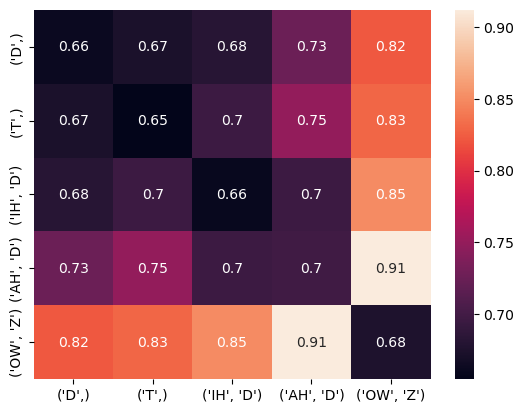

In [37]:
sns.heatmap(study_difference_difference_mat, annot=True,
            xticklabels=study_divergence_contents, yticklabels=study_divergence_contents)

In [38]:
control_study_results = []
for div in study_divergence_contents:
    within_div = cdist(study_vectors_flat[div], study_vectors_flat[div], metric=metric).mean()
    counterfactual_vectors = counterfactual_divergence_vectors[div]
    between_div = cdist(study_vectors_flat[div], counterfactual_vectors, metric=metric).mean()

    control_study_results.append({"divergence": div, "within_div": within_div, "between_div": between_div})

control_study_results_df = pd.DataFrame(control_study_results)
control_study_results_df.to_csv(f"{output_dir}/control_study_results.csv")
control_study_results_df

,divergence,within_div,between_div
0,"(D,)",0.662000,0.998935
1,"(T,)",0.654488,0.953984
2,"(IH, D)",0.659567,0.835173
3,"(AH, D)",0.698618,0.872854
4,"(OW, Z)",0.675309,0.940437
